In [1]:
# %load ../helpers/header.py
SUB_DIR = "Forest"
# load ENV path to project from .profile 
import os, sys
PROJECT_ROOT_DIR=os.environ.get('ML_PATH')
sys.path.append(os.path.join(PROJECT_ROOT_DIR, "helpers")) # add helper modules to path

# MPL 
import MPL_header #load common MPL imports (from helpers)
import matplotlib.pyplot as plt
%matplotlib inline 
# %matplotlib widget 

# NP, constant seed, PD 
import numpy as np
np.random.seed(12345)
import pandas as pd

# Where to save the figures
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "fig", SUB_DIR)
# IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "fig")
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

### Create and train a voting classifier

In [2]:
from sklearn.datasets import make_moons
X, y = make_moons(n_samples=500, noise=0.30, random_state=42)

In [3]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

### Hard voting = majority BINARY voting

In [4]:
from sklearn.ensemble import RandomForestClassifier 
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression 
from sklearn.svm import SVC
    
log_clf = LogisticRegression()
rnd_clf = RandomForestClassifier()
svm_clf = SVC()
voting_clf = VotingClassifier(estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)], voting='hard') # hard = majority binary
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr',
                              LogisticRegression(C=1.0, class_weight=None,
                                                 dual=False, fit_intercept=True,
                                                 intercept_scaling=1,
                                                 l1_ratio=None, max_iter=100,
                                                 multi_class='auto',
                                                 n_jobs=None, penalty='l2',
                                                 random_state=None,
                                                 solver='lbfgs', tol=0.0001,
                                                 verbose=0, warm_start=False)),
                             ('rf',
                              RandomForestClassifier(bootstrap=True,
                                                     ccp_alpha=0.0,
                                                     class_weight=None,
                                             

In [6]:
from sklearn.metrics import accuracy_score
for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)        
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.904
SVC 0.896
VotingClassifier 0.904


### Soft voting - WEIGHTED majority voting

In [7]:
# add predict_proba() methdod 
svm_clf_predict_prob = SVC(probability=True)

In [8]:
voting_clf_soft = VotingClassifier(estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf_predict_prob)], voting='soft') # hard = majority binary
voting_clf_soft.fit(X_train, y_train)

VotingClassifier(estimators=[('lr',
                              LogisticRegression(C=1.0, class_weight=None,
                                                 dual=False, fit_intercept=True,
                                                 intercept_scaling=1,
                                                 l1_ratio=None, max_iter=100,
                                                 multi_class='auto',
                                                 n_jobs=None, penalty='l2',
                                                 random_state=None,
                                                 solver='lbfgs', tol=0.0001,
                                                 verbose=0, warm_start=False)),
                             ('rf',
                              RandomForestClassifier(bootstrap=True,
                                                     ccp_alpha=0.0,
                                                     class_weight=None,
                                             

In [10]:
from sklearn.metrics import accuracy_score
for clf in (log_clf, rnd_clf, svm_clf_predict_prob, voting_clf_soft):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.888
SVC 0.896
VotingClassifier 0.904


### Proper bagging is to use instances of the best classifier on subsets of data
### Predictors can all be trained in parallel, via different CPU cores

# Train an ensemble of 500 Decision Tree classifiers
 each is trained on 100 training instances randomly sampled from the training set with replacement (this is an example of bag‐ ging, but if you want to use pasting instead, just set bootstrap=False).
 ## `n_jobs` parameter tells Scikit-Learn the number of CPU cores to use for training and predic‐ tions (–1 tells Scikit-Learn to use all available cores):

In [11]:
from sklearn.ensemble import BaggingClassifier 
from sklearn.tree import DecisionTreeClassifier
bag_clf = BaggingClassifier(DecisionTreeClassifier(), n_estimators=500, max_samples=100, bootstrap=True, n_jobs=-1)
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

### Out-of-Bag Evaluation (oob): Since a predictor never sees the oob instances during training, it can be evaluated on these instances, without the need for a separate validation set. You can evaluate the ensemble itself by averaging out the oob evaluations of each predictor. (67-37% split)

In [12]:
bag_clf = BaggingClassifier(DecisionTreeClassifier(), n_estimators=500, bootstrap=True, n_jobs=-1, oob_score=True)

In [13]:
bag_clf.fit(X_train, y_train)

BaggingClassifier(base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                        class_weight=None,
                                                        criterion='gini',
                                                        max_depth=None,
                                                        max_features=None,
                                                        max_leaf_nodes=None,
                                                        min_impurity_decrease=0.0,
                                                        min_impurity_split=None,
                                                        min_samples_leaf=1,
                                                        min_samples_split=2,
                                                        min_weight_fraction_leaf=0.0,
                                                        presort='deprecated',
                                                        random_state=None,


In [19]:
print(f"oob evaluation prediction to get {bag_clf.oob_score_} on the test set")

oob evaluation prediction to get 0.896 on the test set


In [21]:
from sklearn.metrics import accuracy_score
y_pred = bag_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.904

In [26]:
print("oob decision function for each training instance...", len(bag_clf.oob_decision_function_))
# bag_clf.oob_decision_function_

oob decision function for each training instance... 375


# Random Patches method:Sampling both training instances and features
# Random Subspaces method: sampling features only
Sampling features results in even more predictor diversity, trading a bit more bias for a lower variance.

# Random Forests (=`BaggingClassifier`+`DecisionTreeClassifier`) -- this is reflected in the hyperpameters: both tree-level and ensamble-level

### Random Forest classifier with 500 trees (each limited to maximum 16 nodes)

In [29]:
from sklearn.ensemble import RandomForestClassifier
rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, n_jobs=-1)
rnd_clf.fit(X_train, y_train)
y_pred_rf = rnd_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.904

## RF are "less gready" (local solution at all cost) wrt DT - algorithm introduces extra randomness when growing trees; instead of searching for the very best feature when splitting a node, it searches for the best feature among a random subset of features.
## Resulting in a greater tree diversity, which (again) trades a higher bias for a lower var‐ iance, generally yielding an overall better model.

## Extra-Trees == Extremely Randomized Trees 
this technique trades more bias for a lower variance. It also makes Extra-Trees much faster to train than regular Random Forests, because finding the best possible threshold for each feature at every node is one of the most time-consuming tasks of growing a tree.

## Feature Importance
## Random Forests are very handy to get a quick understanding of what features actually matter, in particular if you need to perform feature selection.

In [32]:
from sklearn.datasets import load_iris
iris = load_iris()
rnd_clf = RandomForestClassifier(n_estimators=500, n_jobs=-1)
rnd_clf.fit(iris["data"], iris["target"])
for name, score in zip(iris["feature_names"], rnd_clf.feature_importances_):
    print(name, score)

sepal length (cm) 0.08782164637215638
sepal width (cm) 0.021812969747447567
petal length (cm) 0.4507295910459484
petal width (cm) 0.4396357928344476


In [39]:
import matplotlib.pyplot as plt 
import matplotlib as mpl
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.hot,
               interpolation="nearest")
    plt.axis("off")

In [40]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)
mnist.target = mnist.target.astype(np.uint8)

In [35]:
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rnd_clf.fit(mnist["data"], mnist["target"])

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

Saving figure mnist_feature_importance_plot


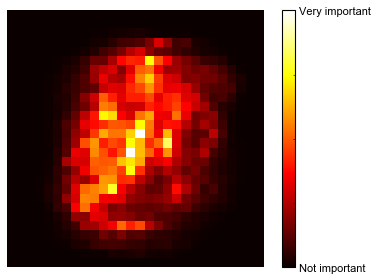

In [41]:
plot_digit(rnd_clf.feature_importances_)

cbar = plt.colorbar(ticks=[rnd_clf.feature_importances_.min(), rnd_clf.feature_importances_.max()])
cbar.ax.set_yticklabels(['Not important', 'Very important'])

save_fig("mnist_feature_importance_plot")
plt.show()

### Boosting: sequential learning (on residuals)
#### sequential learning technique has some similarities with Gradient Descent
Cannot be parallelised as well as bagging (obviously)

The following code trains an AdaBoost classifier based on 200 Decision Stumps (Decision Tree with max_depth=1)using Scikit-Learn’s AdaBoostClassifier class
### If your AdaBoost ensemble is overfitting the training set, you can try reducing the number of estimators or more strongly regulariz‐ ing the base estimator.

In [42]:
from sklearn.ensemble import AdaBoostClassifier
ada_clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1), n_estimators=200, algorithm="SAMME.R", learning_rate=0.5)
ada_clf.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME.R',
                   base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                         class_weight=None,
                                                         criterion='gini',
                                                         max_depth=1,
                                                         max_features=None,
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                                         min_samples_split=2,
                                                         min_weight_fraction_leaf=0.0,
                                                         presort='deprecated',
                          

In [45]:
from matplotlib.colors import ListedColormap
def plot_decision_boundary(clf, X, y, axes=[-1.5, 2.45, -1, 1.5], alpha=0.5, contour=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if contour:
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", alpha=alpha)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", alpha=alpha)
    plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)

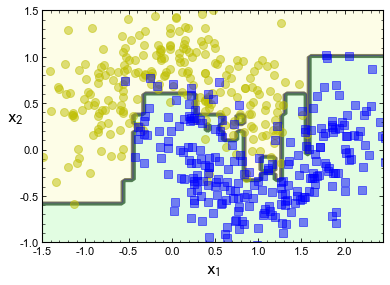

In [46]:
plot_decision_boundary(ada_clf, X, y)

### Gradient Boosting: e.g. 3 regressors, on residuals -- verbose method for plotting only 

In [47]:
np.random.seed(42)
X = np.random.rand(100, 1) - 0.5
y = 3*X[:, 0]**2 + 0.05 * np.random.randn(100)

In [48]:
from sklearn.tree import DecisionTreeRegressor

tree_reg1 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg1.fit(X, y)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=2,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=42, splitter='best')

In [50]:
y2 = y - tree_reg1.predict(X)
tree_reg2 = DecisionTreeRegressor(max_depth=2)
tree_reg2.fit(X, y2)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=2,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

In [52]:
y3 = y2 - tree_reg2.predict(X)
tree_reg3 = DecisionTreeRegressor(max_depth=2)
tree_reg3.fit(X, y3)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=2,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

In [55]:
X_new = np.array([[0.8]])
y_pred = sum(tree.predict(X_new) for tree in (tree_reg1, tree_reg2, tree_reg3))
y_pred

array([0.75026781])

In [56]:
def plot_predictions(regressors, X, y, axes, label=None, style="r-", data_style="b.", data_label=None):
    x1 = np.linspace(axes[0], axes[1], 500)
    y_pred = sum(regressor.predict(x1.reshape(-1, 1)) for regressor in regressors)
    plt.plot(X[:, 0], y, data_style, label=data_label)
    plt.plot(x1, y_pred, style, linewidth=2, label=label)
    if label or data_label:
        plt.legend(loc="upper center", fontsize=16)
    plt.axis(axes)

Saving figure gradient_boosting_plot


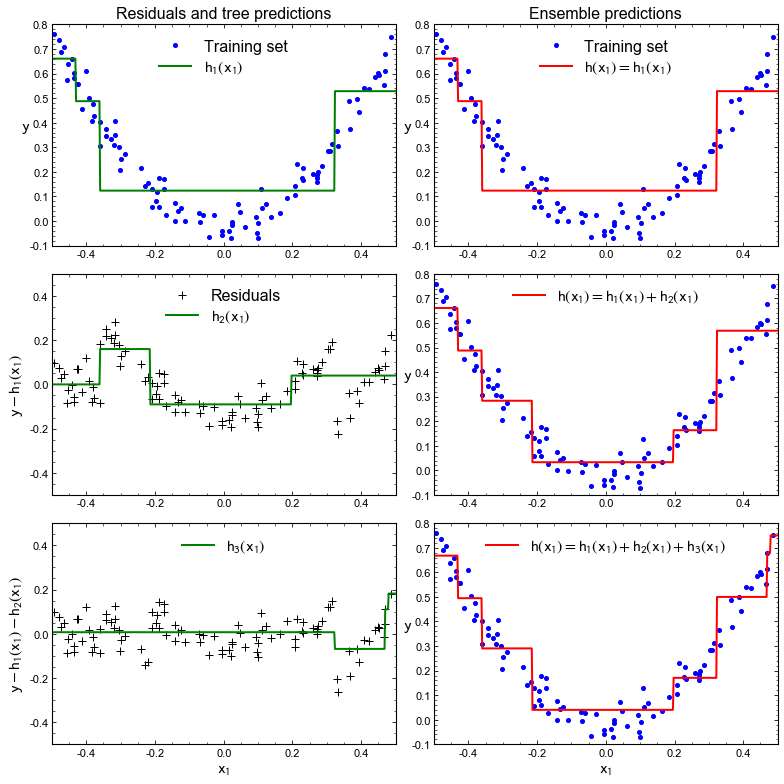

In [57]:
plt.figure(figsize=(11,11))

plt.subplot(321)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h_1(x_1)$", style="g-", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Residuals and tree predictions", fontsize=16)

plt.subplot(322)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1)$", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Ensemble predictions", fontsize=16)

plt.subplot(323)
plot_predictions([tree_reg2], X, y2, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_2(x_1)$", style="g-", data_style="k+", data_label="Residuals")
plt.ylabel("$y - h_1(x_1)$", fontsize=16)

plt.subplot(324)
plot_predictions([tree_reg1, tree_reg2], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1)$")
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.subplot(325)
plot_predictions([tree_reg3], X, y3, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_3(x_1)$", style="g-", data_style="k+")
plt.ylabel("$y - h_1(x_1) - h_2(x_1)$", fontsize=16)
plt.xlabel("$x_1$", fontsize=16)

plt.subplot(326)
plot_predictions([tree_reg1, tree_reg2, tree_reg3], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1) + h_3(x_1)$")
plt.xlabel("$x_1$", fontsize=16)
plt.ylabel("$y$", fontsize=16, rotation=0)

save_fig("gradient_boosting_plot")
plt.show()

## A one-liner WTF 

In [58]:
from sklearn.ensemble import GradientBoostingRegressor
gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=3, learning_rate=1.0)
gbrt.fit(X, y)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=1.0, loss='ls', max_depth=2,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=3,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [59]:
X_new = np.array([[0.8]])
y_pred = sum(tree.predict(X_new) for tree in (tree_reg1, tree_reg2, tree_reg3))
y_pred

array([0.75026781])

## Gradient Boosting with Early stopping

In [60]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=49)

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=120, random_state=42)
gbrt.fit(X_train, y_train)

errors = [mean_squared_error(y_val, y_pred)
          for y_pred in gbrt.staged_predict(X_val)]
bst_n_estimators = np.argmin(errors) + 1

gbrt_best = GradientBoostingRegressor(max_depth=2, n_estimators=bst_n_estimators, random_state=42)
gbrt_best.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=2,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=56,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=42, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [61]:
min_error = np.min(errors)

Saving figure early_stopping_gbrt_plot


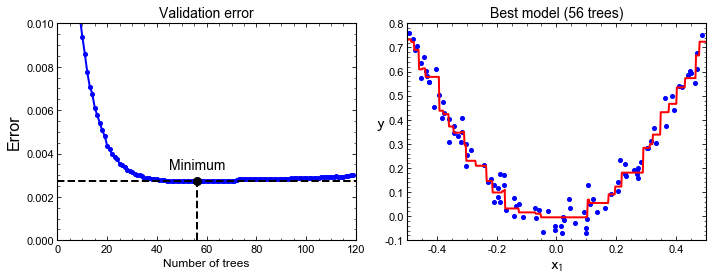

In [62]:
plt.figure(figsize=(10, 4))

plt.subplot(121)
plt.plot(errors, "b.-")
plt.plot([bst_n_estimators, bst_n_estimators], [0, min_error], "k--")
plt.plot([0, 120], [min_error, min_error], "k--")
plt.plot(bst_n_estimators, min_error, "ko")
plt.text(bst_n_estimators, min_error*1.2, "Minimum", ha="center", fontsize=14)
plt.axis([0, 120, 0, 0.01])
plt.xlabel("Number of trees")
plt.ylabel("Error", fontsize=16)
plt.title("Validation error", fontsize=14)

plt.subplot(122)
plot_predictions([gbrt_best], X, y, axes=[-0.5, 0.5, -0.1, 0.8])
plt.title("Best model (%d trees)" % bst_n_estimators, fontsize=14)
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.xlabel("$x_1$", fontsize=16)

save_fig("early_stopping_gbrt_plot")
plt.show()

### It is also possible to implement early stopping by actually stopping training early

In [63]:
gbrt = GradientBoostingRegressor(max_depth=2, warm_start=True, random_state=42)

min_val_error = float("inf")
error_going_up = 0
for n_estimators in range(1, 120):
    gbrt.n_estimators = n_estimators
    gbrt.fit(X_train, y_train)
    y_pred = gbrt.predict(X_val)
    val_error = mean_squared_error(y_val, y_pred)
    if val_error < min_val_error:
        min_val_error = val_error
        error_going_up = 0
    else:
        error_going_up += 1
        if error_going_up == 5:
            break  # early stopping

In [64]:
print(gbrt.n_estimators)

61


In [65]:
print("Minimum validation MSE:", min_val_error)

Minimum validation MSE: 0.002712853325235463


# It is possible to use Gradient Boosting with other cost functions. This is controlled by the loss hyperparameter

# XGBoost

In [66]:
import xgboost
xgb_reg = xgboost.XGBRegressor()
xgb_reg.fit(X_train, y_train)
y_pred = xgb_reg.predict(X_val)

In [67]:
# automatic early stopping
xgb_reg.fit(X_train, y_train, eval_set=[(X_val, y_val)], early_stopping_rounds=2)
y_pred = xgb_reg.predict(X_val)

[0]	validation_0-rmse:0.22834
Will train until validation_0-rmse hasn't improved in 2 rounds.
[1]	validation_0-rmse:0.16224
[2]	validation_0-rmse:0.11843
[3]	validation_0-rmse:0.08760
[4]	validation_0-rmse:0.06848
[5]	validation_0-rmse:0.05709
[6]	validation_0-rmse:0.05297
[7]	validation_0-rmse:0.05129
[8]	validation_0-rmse:0.05155
[9]	validation_0-rmse:0.05211
Stopping. Best iteration:
[7]	validation_0-rmse:0.05129



# Stacking: nstead of using trivial functions (such as hard voting) to aggregate the predictions of all predictors in an ensemble, why don’t we train a model to perform this aggregation?

### Blender takes output from ensamble algorithms. To train the blender, a common approach is to use a hold-out set

The trick is to split the training set into three subsets: the first one is used to train the first layer, the second one is used to create the training set used to train the second layer (using predictions made by the predictors of the first layer), and the third one is used to create the training set to train the third layer (using predictions made by the predictors of the second layer).  Unfortunately, Scikit-Learn does not support stacking directly, but it is not too hard to roll out your own implementation (see the following exercises). Alternatively, you can use an open source implementation such as DESlib.

In [70]:
# %timeit xgb_reg.fit(X_train, y_train, eval_set=[(X_val, y_val)], early_stopping_rounds=2)

# What is the benefit of out-of-bag evaluation?

With out-of-bag evaluation, each predictor in a bagging ensemble is evaluated using instances that it was not trained on (they were held out). This makes it pos‐ sible to have a fairly unbiased evaluation of the ensemble without the need for an additional validation set. Thus, you have more instances available for training, and your ensemble can perform slightly better.